In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


In [128]:
test_name = 'anomaly1_FL_5epochs'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/synthetic/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2', 'anomaly3']

    data = pd.read_csv(file,
                    names = names)
    
    datas.append(data)

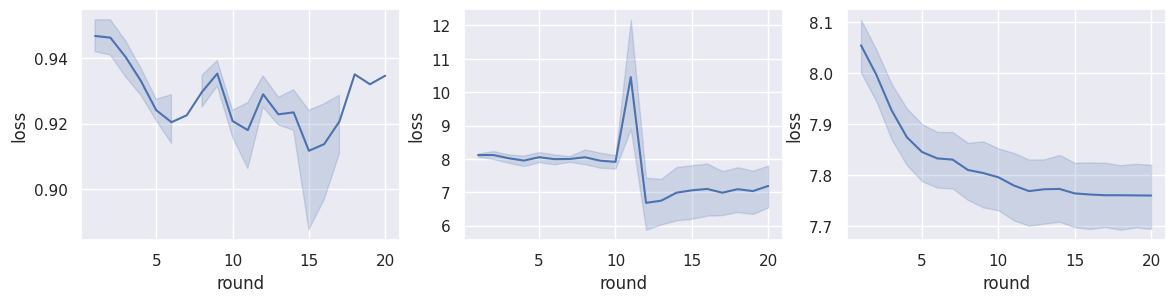

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i])#, hue='cid', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

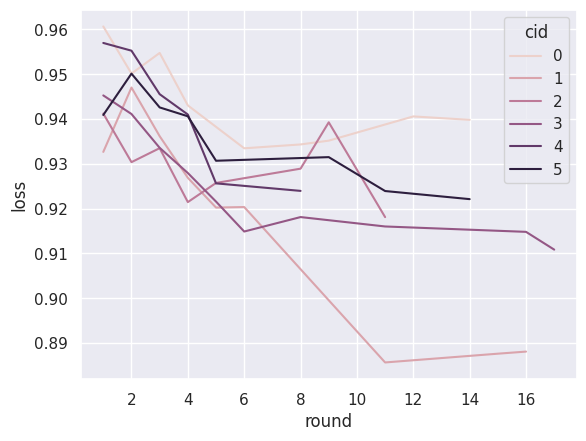

In [171]:
sns.lineplot(datas[0][datas[0]['cid'].isin( [0,1,2,3,4,5])], x = 'round', y = 'loss', hue = 'cid')

In [169]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    cids = [0,1,2,3,4]

    #df['true_anomaly'] = df['round'].apply(lambda x: 1 if x>=10 else 0)
    #idx = df[df['cid'].isin(cids)].index.values[0] 
    #df.at[idx, 'true_anomaly']= 1
    df['true_anomaly'] = 0
    df.loc[(df['cid'].isin(cids)*df['round'].isin([11])), ['true_anomaly']] = 1

    th = 1.5

    for cid in range(15):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['loss'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly',f1_score(data['true_anomaly'], data['anomaly']),
        precision_score(       data['true_anomaly'], data['anomaly']),
        recall_score(          data['true_anomaly'], data['anomaly']),
        accuracy_score(        data['true_anomaly'], data['anomaly']))

    print('Anomaly2',f1_score(data['true_anomaly'], data['anomaly2']),
        precision_score(       data['true_anomaly'], data['anomaly2']),
        recall_score(          data['true_anomaly'], data['anomaly2']),
        accuracy_score(        data['true_anomaly'], data['anomaly2']))

    print('Anomaly3',f1_score(data['true_anomaly'],  data['anomaly3']),
        precision_score(       data['true_anomaly'], data['anomaly3']),
        recall_score(          data['true_anomaly'], data['anomaly3']),
        accuracy_score(        data['true_anomaly'], data['anomaly3']))
    
    print('Anomaly32',f1_score(data['true_anomaly'], data['anomaly32']),
        precision_score(       data['true_anomaly'], data['anomaly32']),
        recall_score(          data['true_anomaly'], data['anomaly32']),
        accuracy_score(        data['true_anomaly'], data['anomaly32']))
    
    
    print('-----------')


Anomaly 0.0 0.0 0.0 0.9758064516129032
Anomaly2 0.0 0.0 0.0 0.9758064516129032
Anomaly3 0.0 0.0 0.0 0.9354838709677419
Anomaly32 0.0 0.0 0.0 0.9354838709677419
-----------
Anomaly 1.0 1.0 1.0 1.0
Anomaly2 0.125 0.06976744186046512 0.6 0.8590604026845637
Anomaly3 0.013157894736842105 0.006802721088435374 0.2 0.4966442953020134
Anomaly32 0.03508771929824561 0.018072289156626505 0.6 0.4463087248322148
-----------
Anomaly 0.0 0.0 0.0 0.9865319865319865
Anomaly2 0.0 0.0 0.0 0.9562289562289562
Anomaly3 0.04166666666666666 0.02142857142857143 0.75 0.5353535353535354
Anomaly32 0.0410958904109589 0.02112676056338028 0.75 0.5286195286195287
-----------


In [167]:
data['anomaly'].value_counts()

0    297
Name: anomaly, dtype: int64

In [164]:
data[data['round'] == 11]

,cid,round,loss,diff,anomaly,anomaly2,anomaly3,anom_true,anomaly12,true_anomaly,anomaly32
150,8,11,7.561983,0.301962,0,0,1,2,0,0,1
151,6,11,7.835251,0.028693,0,0,1,2,0,0,1
152,1,11,7.843766,0.008514,0,0,1,2,0,1,1
153,14,11,7.570185,0.273580,0,0,1,2,0,0,1
154,9,11,7.710394,0.133372,0,0,1,2,0,0,1
155,4,11,7.978535,0.134769,0,0,1,2,0,1,1
156,7,11,7.896942,0.081593,0,0,1,2,0,0,1
157,10,11,7.706371,0.272164,0,0,1,2,0,0,1
158,12,11,7.829170,0.122799,0,0,1,2,0,0,1
159,2,11,7.887404,0.058234,0,0,1,2,0,1,1


In [172]:
#testar sem parar o treinamento dos clientes anomalos
#testar usando outras anomalias
#testar sem anomalias